# Importing Packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys




# Reading the images

In [2]:
tumor = []
healthy = []
for f in glob.iglob("./Dataset/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./Dataset/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [3]:
print(len(healthy))
print(len(tumor))

1500
1500


In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [5]:
healthy.shape

(1500, 128, 128, 3)

In [6]:
tumor.shape

(1500, 128, 128, 3)

In [7]:
np.random.choice(10, 5, replace=False)

array([9, 7, 6, 1, 3])

# Visualizing Brain MRI Images

In [8]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
        

    

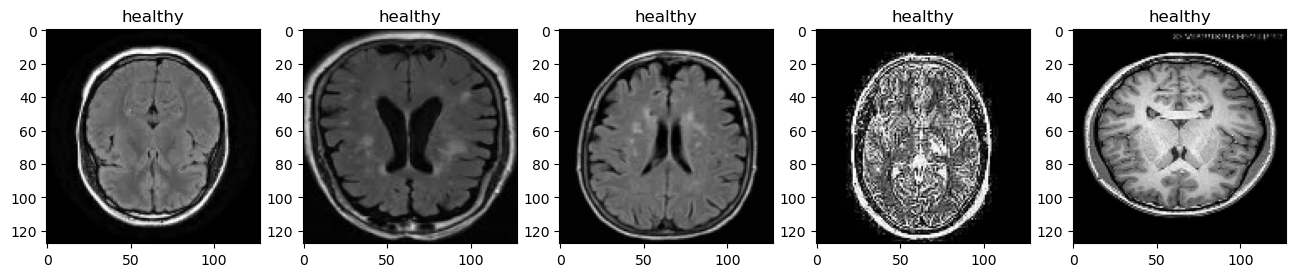

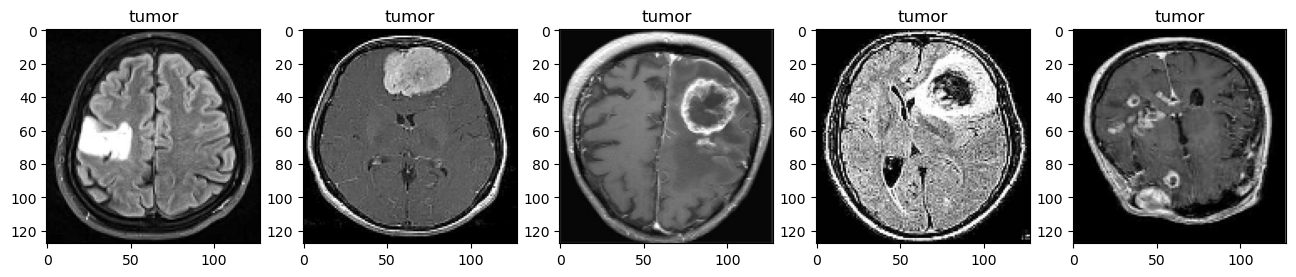

In [9]:
plot_random(healthy, tumor, num=5)

# Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [10]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Creating MRI custom dataset class

In [11]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./Dataset/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./Dataset/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [12]:
mri_dataset = MRI()
mri_dataset.normalize()

In [13]:
print(len(mri_dataset))

3000


# Creating a dataloader

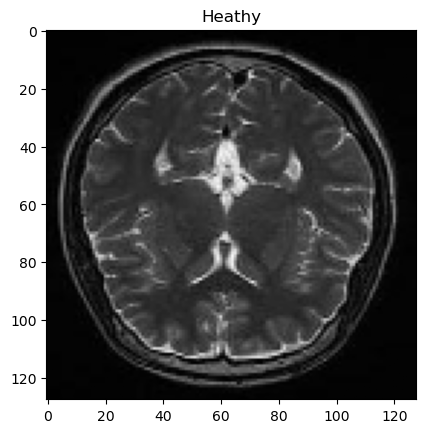

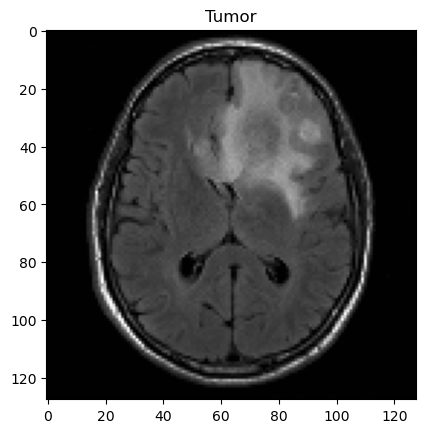

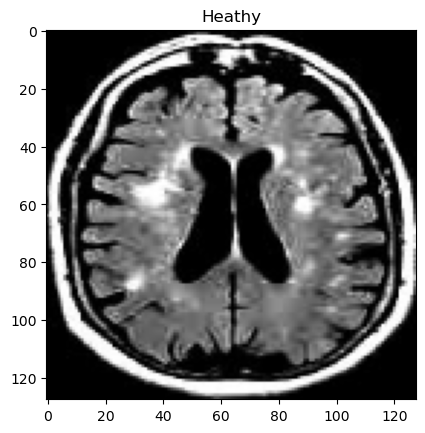

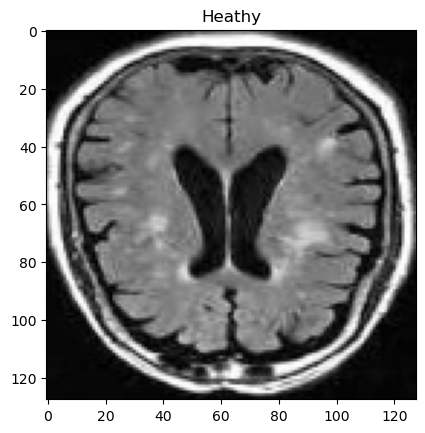

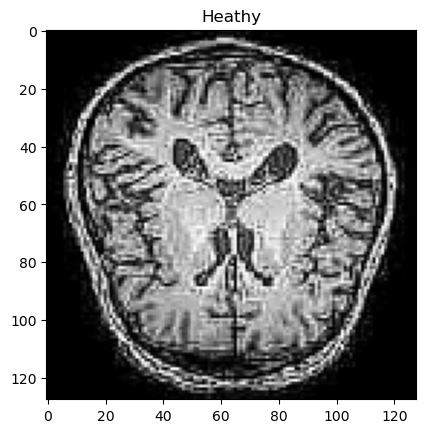

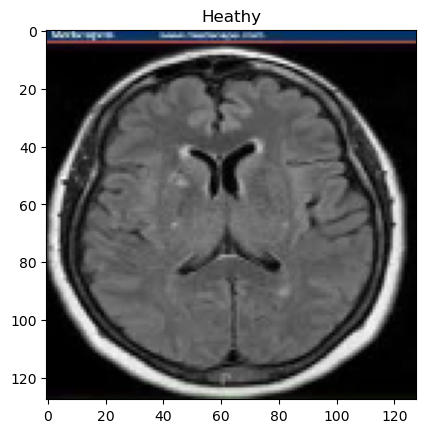

In [14]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [16]:
model = CNN()

In [17]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [18]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [19]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[ 0.0737,  0.0712,  0.0836, -0.0596,  0.0197],
          [ 0.0024, -0.0138,  0.0301, -0.0486,  0.1079],
          [-0.0007,  0.0661, -0.1109,  0.0868, -0.0186],
          [-0.0986,  0.1154, -0.0560, -0.0627, -0.0764],
          [ 0.1001,  0.0514,  0.1058,  0.0197, -0.0643]],

         [[-0.0430, -0.0163, -0.1137,  0.0051, -0.0341],
          [-0.1057, -0.0724,  0.1088, -0.0999, -0.0512],
          [ 0.0677, -0.1103, -0.1072, -0.0100,  0.0268],
          [ 0.0205, -0.0352, -0.0563, -0.0094, -0.0057],
          [-0.0693, -0.1112,  0.1084, -0.0842, -0.0412]],

         [[ 0.0737, -0.1082, -0.0567, -0.0384,  0.0803],
          [ 0.0051, -0.0144, -0.0239, -0.0254,  0.0407],
          [ 0.0590,  0.0390,  0.0050,  0.0012, -0.0527],
          [-0.0549,  0.0543,  0.0520,  0.0150,  0.0779],
          [-0.0317,  0.0695,  0.0075, -0.0112, -0.0739]]],


        [[[-0.0254,  0.1060, -0.0148,  0.0233,  0.0527],
          [ 0.1058, -0.1015, -0.0679, -0.0063, -0.0310],
 

In [20]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [21]:
model.fc_model[0].weight

Parameter containing:
tensor([[ 0.0335,  0.0449, -0.0362,  ..., -0.0309, -0.0524,  0.0554],
        [-0.0275,  0.0357, -0.0573,  ...,  0.0093, -0.0040, -0.0327],
        [ 0.0153, -0.0613, -0.0007,  ..., -0.0057, -0.0153, -0.0206],
        ...,
        [-0.0364, -0.0234, -0.0400,  ...,  0.0127, -0.0071,  0.0241],
        [-0.0480, -0.0292,  0.0421,  ...,  0.0316,  0.0592,  0.0552],
        [-0.0350,  0.0176, -0.0621,  ...,  0.0378, -0.0338, -0.0610]],
       requires_grad=True)

# torch.tensor vs. torch.cuda.tensor

here key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU.

In [22]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.6910, 0.8153, 0.4725, 0.9501, 0.9183, 0.2980, 0.2734, 0.3778, 0.0528,
        0.5950]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.6910, 0.8153, 0.4725, 0.9501, 0.9183, 0.2980, 0.2734, 0.3778, 0.0528,
        0.5950]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.4775, 0.6647, 0.2232, 0.9028, 0.8432, 0.0888, 0.0747, 0.1427, 0.0028,
        0.3540])


# Evaluate a New-Born Neural Network!

In [23]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')
model = CNN().to(device)


In [24]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [25]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [26]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [27]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [28]:
accuracy_score(y_true, threshold(outputs))

0.5

In [29]:
from sklearn.metrics import classification_report
print (classification_report(y_true, threshold(outputs)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1500
         1.0       0.50      1.00      0.67      1500

    accuracy                           0.50      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.25      0.50      0.33      3000



C:\Users\mshiv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mshiv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mshiv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Positives(TP) =  0
True Negatives(TN) =  1500
False Positives(FP) =  1500
False Negatives(FN) =  0


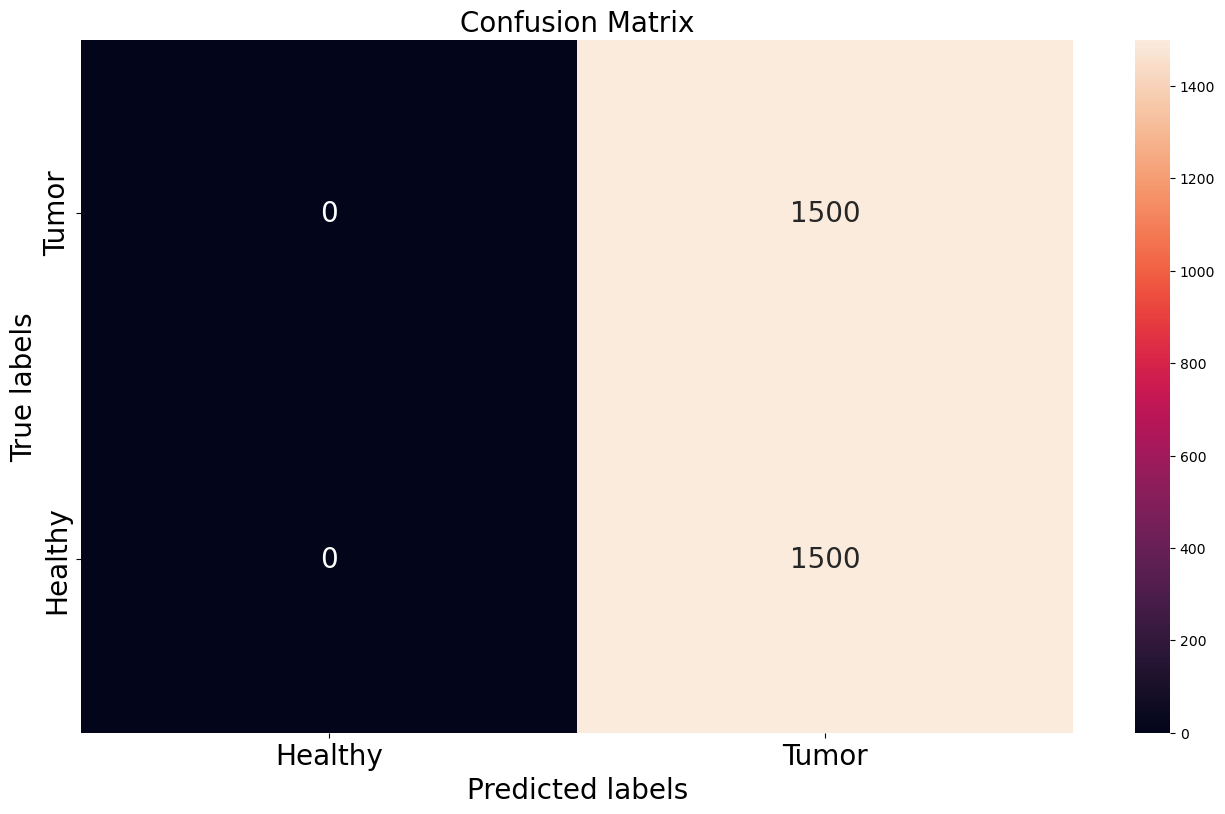

In [30]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)



print('True Positives(TP) = ', cm[0,0])
print('True Negatives(TN) = ', cm[1,1])
print('False Positives(FP) = ', cm[0,1])
print('False Negatives(FN) = ', cm[1,0])

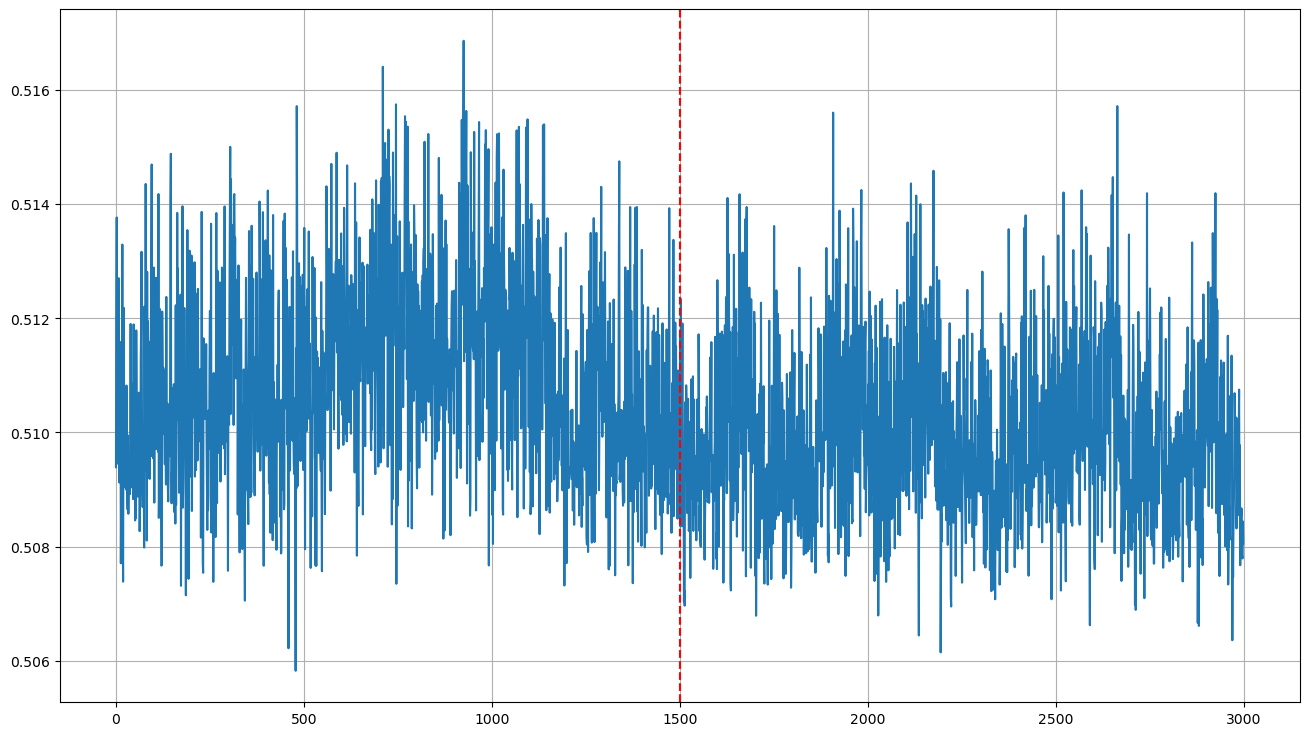

In [31]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


# Train the dumb model

In [32]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [33]:
import torch
import torch.nn as nn
import numpy as np

# Assuming you have val_dataset and val_dataloader defined similarly to train dataset and dataloader

best_loss = float('inf')
early_stop_patience = 5
no_improvement_counter = 0

for epoch in range(1, EPOCH + 1):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    mean_loss = np.mean(losses)
    print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, mean_loss))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for val_D in dataloader:
            val_data = val_D['image'].to(device)
            val_label = val_D['label'].to(device)
            val_y_hat = model(val_data)
            val_loss = torch.sum(error(val_y_hat.squeeze(), val_label))
            val_losses.append(val_loss.item())
        
        mean_val_loss = np.mean(val_losses)
        print('Validation Loss: {:.6f}'.format(mean_val_loss))
        
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
        
        if no_improvement_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break
            
   
    model.train()  # set the model back to training mode


Train Epoch: 1	Loss: 0.678183
Validation Loss: 0.658802
Train Epoch: 2	Loss: 0.616192
Validation Loss: 0.572842
Train Epoch: 3	Loss: 0.553910
Validation Loss: 0.532920
Train Epoch: 4	Loss: 0.517737
Validation Loss: 0.501046
Train Epoch: 5	Loss: 0.488960
Validation Loss: 0.482238
Train Epoch: 6	Loss: 0.473440
Validation Loss: 0.464517
Train Epoch: 7	Loss: 0.464333
Validation Loss: 0.456042
Train Epoch: 8	Loss: 0.456302
Validation Loss: 0.452864
Train Epoch: 9	Loss: 0.456756
Validation Loss: 0.447062
Train Epoch: 10	Loss: 0.450700
Validation Loss: 0.438766
Train Epoch: 11	Loss: 0.439622
Validation Loss: 0.447474
Train Epoch: 12	Loss: 0.434742
Validation Loss: 0.429587
Train Epoch: 13	Loss: 0.429752
Validation Loss: 0.422116
Train Epoch: 14	Loss: 0.423659
Validation Loss: 0.417702
Train Epoch: 15	Loss: 0.420710
Validation Loss: 0.410928
Train Epoch: 16	Loss: 0.414700
Validation Loss: 0.407925
Train Epoch: 17	Loss: 0.410902
Validation Loss: 0.418682
Train Epoch: 18	Loss: 0.402592
Validatio

Validation Loss: 0.040008
Train Epoch: 145	Loss: 0.048577
Validation Loss: 0.134957
Train Epoch: 146	Loss: 0.051408
Validation Loss: 0.039931
Early stopping triggered!


# Evaluate a smart model

In [34]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [35]:
accuracy_score(y_true, threshold(outputs))

0.9926666666666667

In [36]:
print (classification_report(y_true, threshold(outputs)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1500
         1.0       1.00      0.99      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



True Positives(TP) =  1496
True Negatives(TN) =  1482
False Positives(FP) =  4
False Negatives(FN) =  18


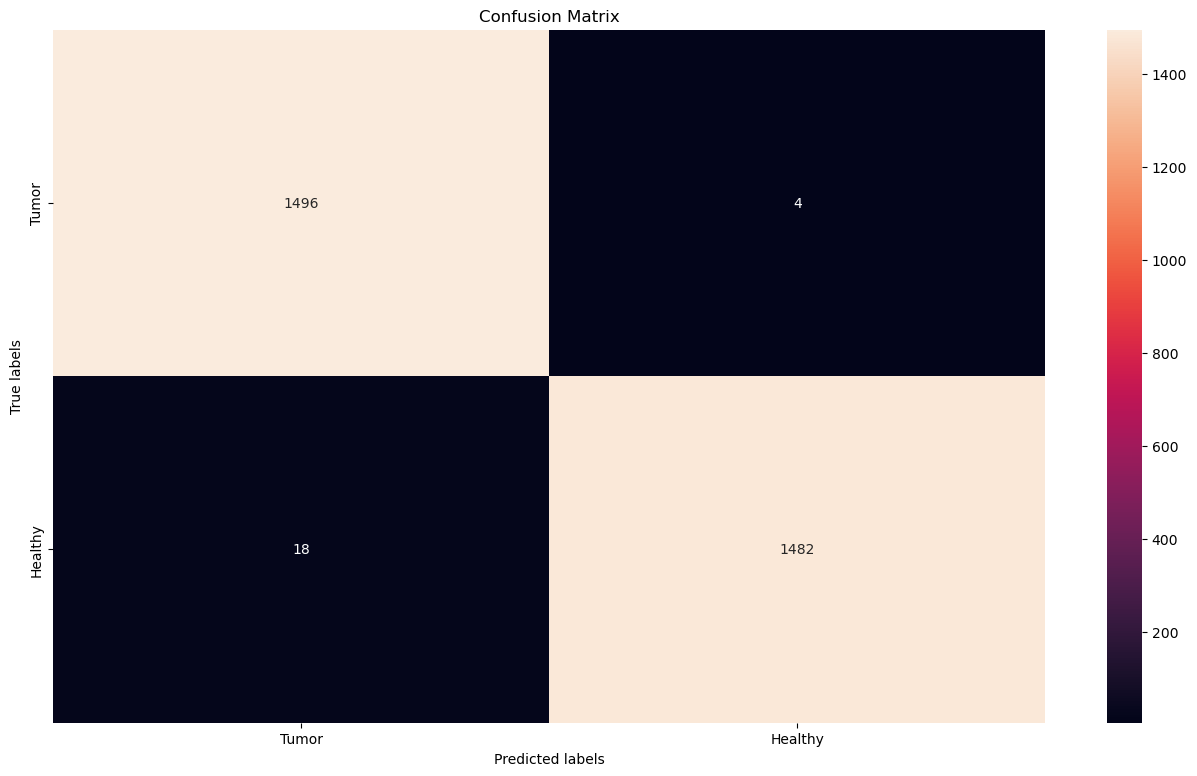

In [37]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])


print('True Positives(TP) = ', cm[0,0])
print('True Negatives(TN) = ', cm[1,1])
print('False Positives(FP) = ', cm[0,1])
print('False Negatives(FN) = ', cm[1,0])

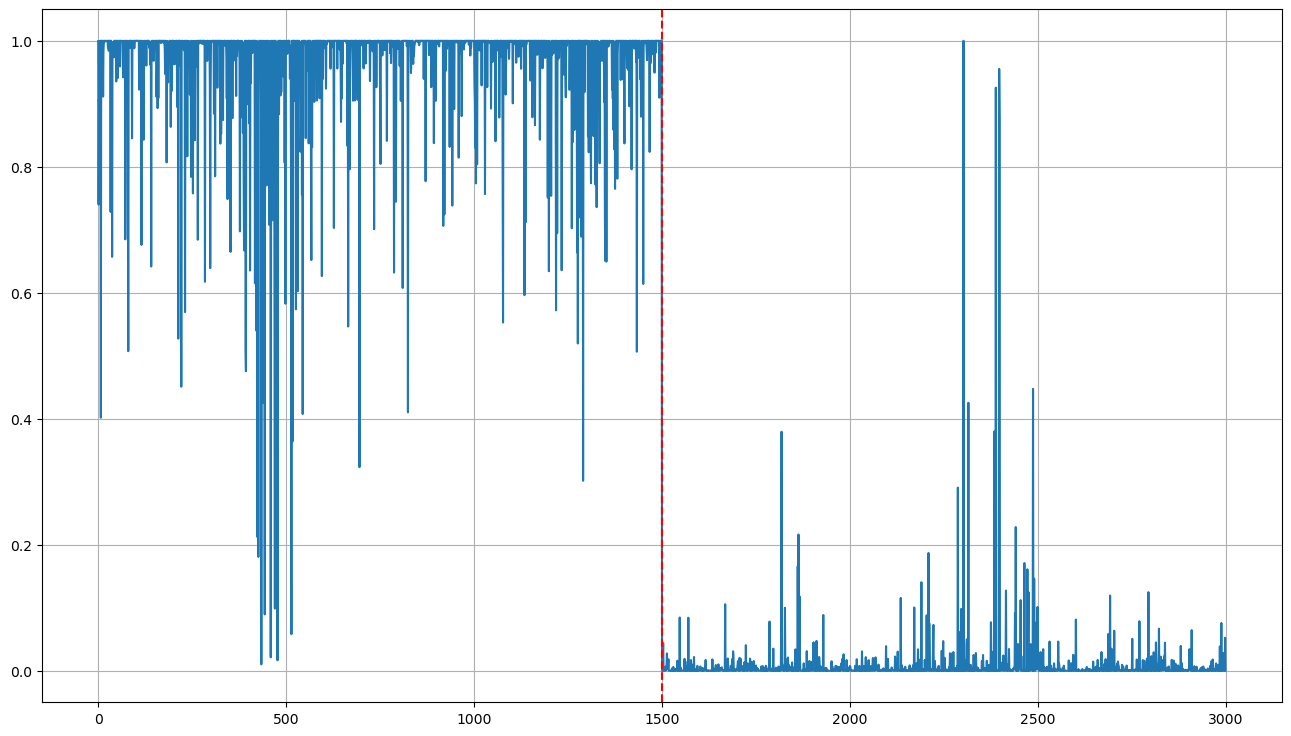

In [38]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [39]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [40]:
no_of_layers = 0
conv_layers = []

In [41]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [42]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [43]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

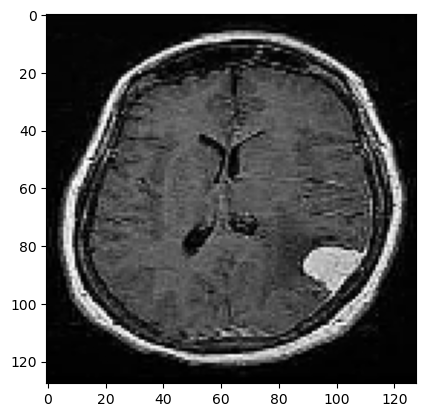

In [44]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [45]:
img = torch.from_numpy(img).to(device)

In [46]:
img.shape

torch.Size([3, 128, 128])

In [47]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [48]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


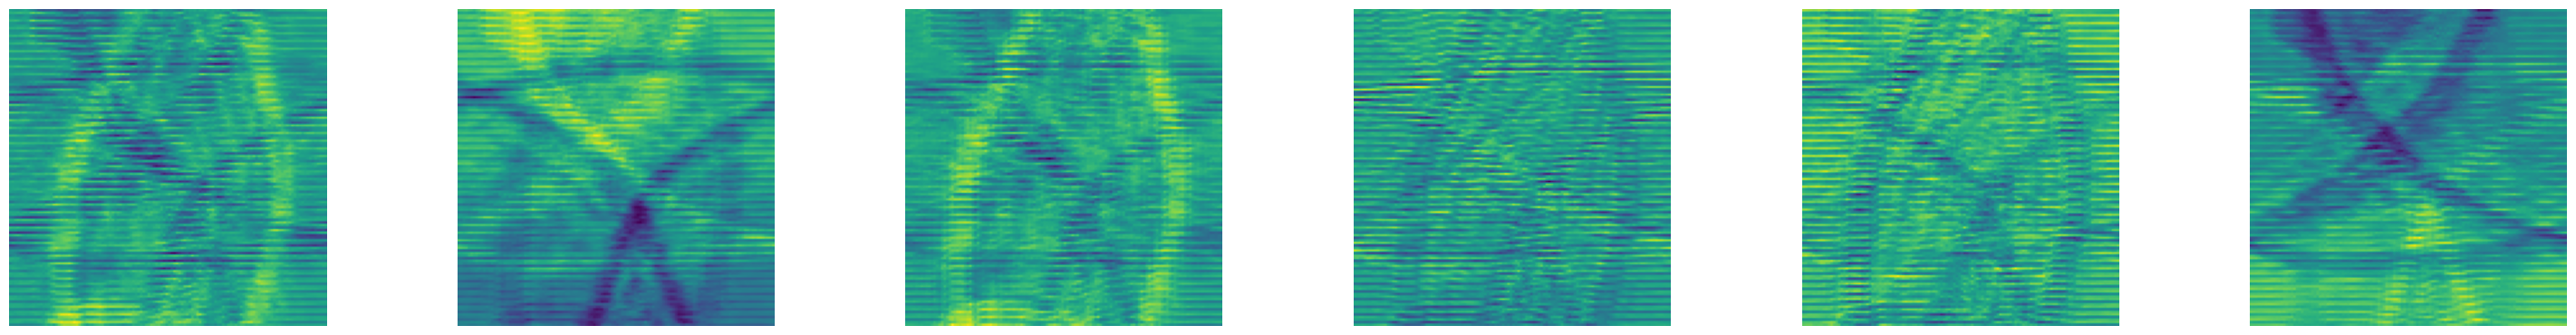

Layer  2


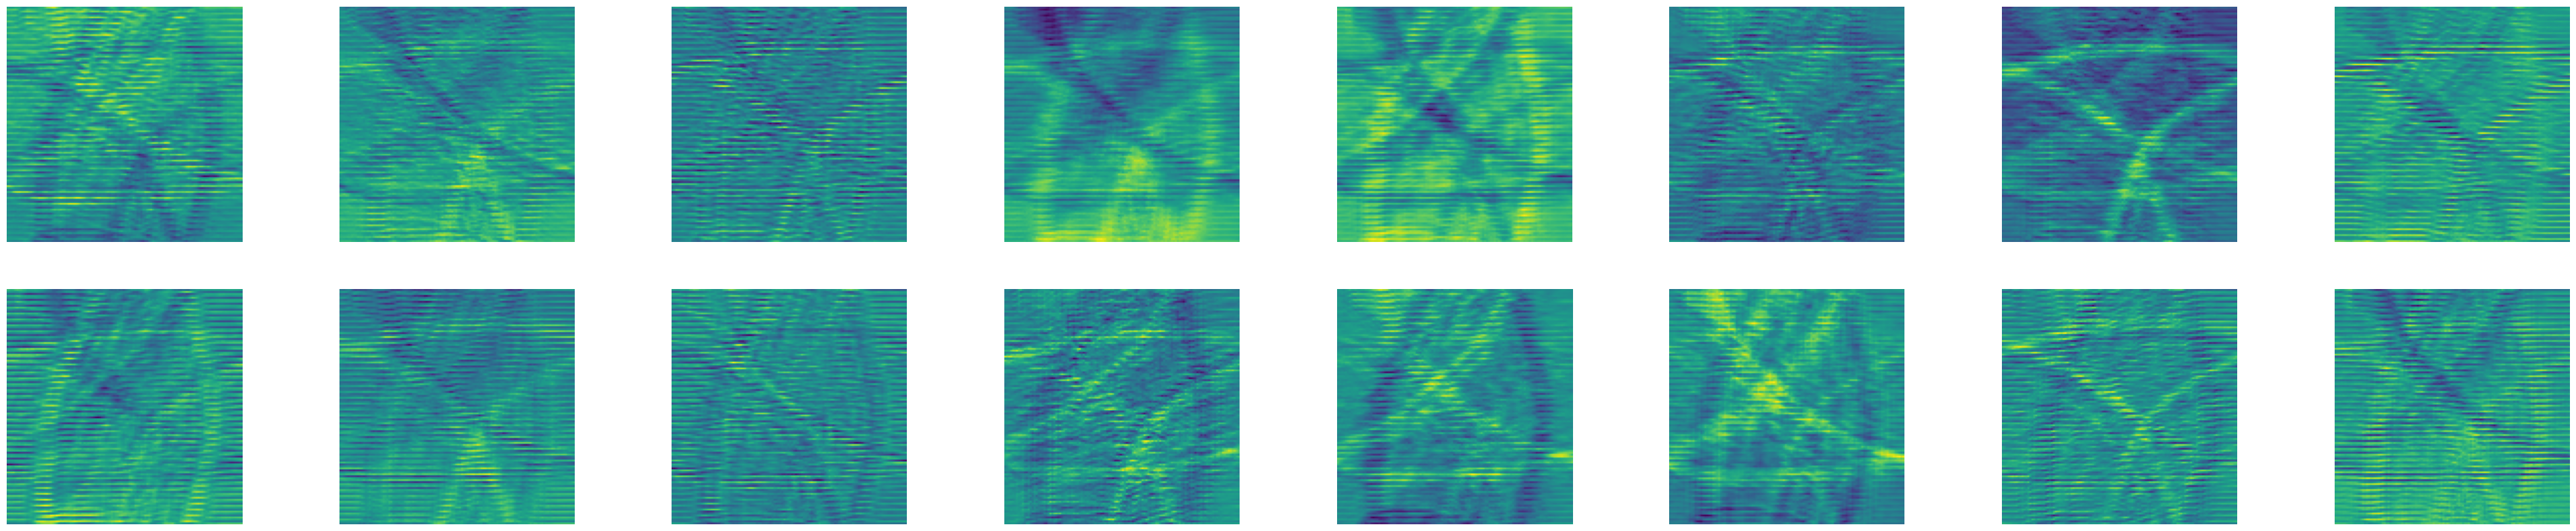

In [49]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are We Over-fitting?

## Preparing a validation set: We need to change the MRI dataset slightly!

In [50]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [51]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./Dataset/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./Dataset/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [52]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [53]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [54]:
device = torch.device("cpu:0")
model = CNN().to(device)

In [55]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [56]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [57]:
import numpy as np


best_val_loss = float('inf')
patience = 20  
counter = 0 

for epoch in range(1, 600): 
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    # Check for early stopping
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}.')
            break

    print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch, np.mean(train_losses),
                                                                          np.mean(val_losses)))


Train Epoch: 1	Train Loss: 0.669494	Val Loss: 0.643426
Train Epoch: 2	Train Loss: 0.591551	Val Loss: 0.627911
Train Epoch: 3	Train Loss: 0.557960	Val Loss: 0.595610
Train Epoch: 4	Train Loss: 0.537794	Val Loss: 0.591798
Train Epoch: 5	Train Loss: 0.520132	Val Loss: 0.572500
Train Epoch: 6	Train Loss: 0.503059	Val Loss: 0.575735
Train Epoch: 7	Train Loss: 0.490988	Val Loss: 0.553577
Train Epoch: 8	Train Loss: 0.479664	Val Loss: 0.546228
Train Epoch: 9	Train Loss: 0.470373	Val Loss: 0.541329
Train Epoch: 10	Train Loss: 0.464824	Val Loss: 0.533638
Train Epoch: 11	Train Loss: 0.454634	Val Loss: 0.527741
Train Epoch: 12	Train Loss: 0.448182	Val Loss: 0.526341
Train Epoch: 13	Train Loss: 0.437483	Val Loss: 0.515499
Train Epoch: 14	Train Loss: 0.428141	Val Loss: 0.526067
Train Epoch: 15	Train Loss: 0.421995	Val Loss: 0.517686
Train Epoch: 16	Train Loss: 0.414697	Val Loss: 0.502823
Train Epoch: 17	Train Loss: 0.409346	Val Loss: 0.497572
Train Epoch: 18	Train Loss: 0.408860	Val Loss: 0.491503
T

Text(0, 0.5, 'Loss')

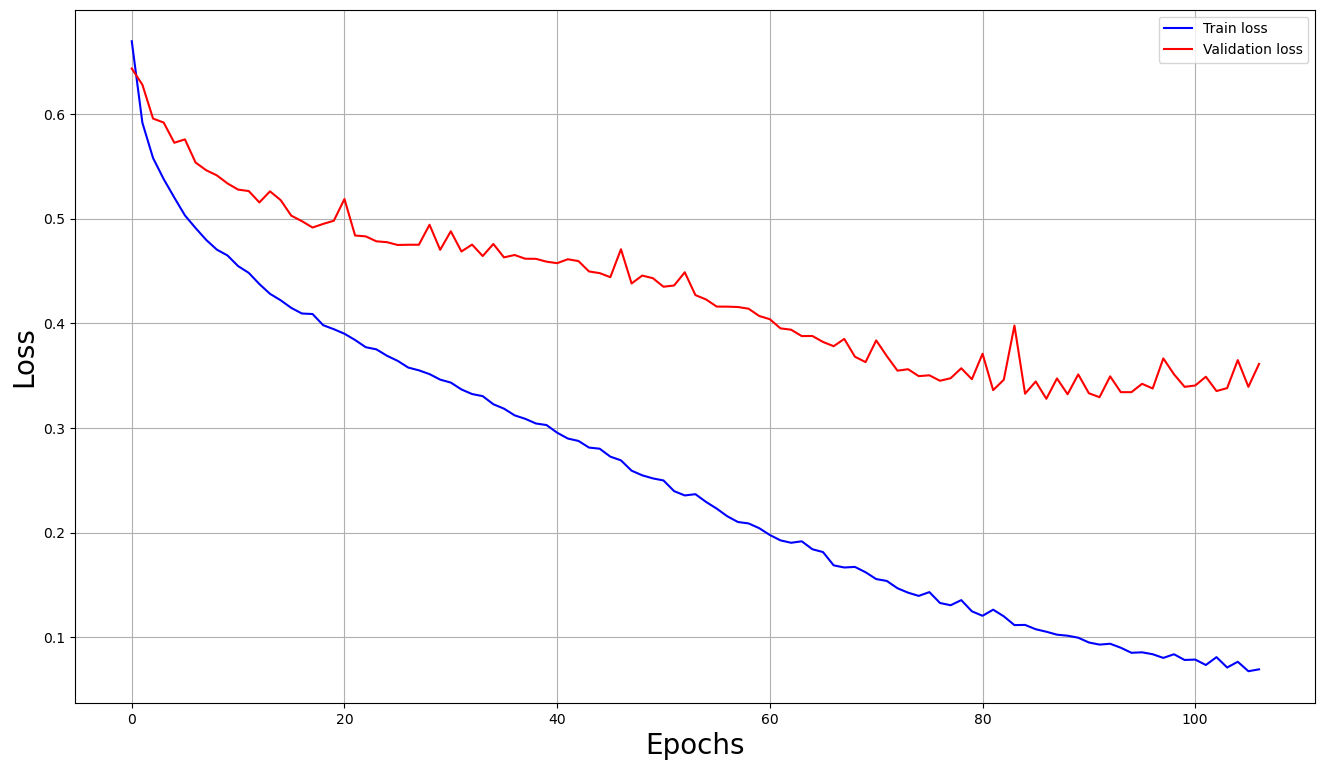

In [58]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)